In [3]:
from collections import defaultdict

import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import NMF, PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline

from mcda.dataset import MCDADataset
from methods.mvu import MaximumVarianceUnfolding

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [7]:
df = MCDADataset.read_csv("./data/ceiling-structures/dataset.csv").data

In [8]:
methods = {
    "PCA": Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2, random_state=42))]),
    "KernelPCA": Pipeline([('scaler', StandardScaler()), ('kpca', KernelPCA(n_components=2, random_state=42))]),
    "MDS": Pipeline([('scaler', StandardScaler()), ('mds', MDS(n_components=2, random_state=42))]),
    "LLE": Pipeline([('scaler', StandardScaler()), ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))]),
    "Isomap": Pipeline([('scaler', StandardScaler()), ('isomap', Isomap(n_components=2))]),
    "MVU": Pipeline([('scaler', StandardScaler()), ('isomap', MaximumVarianceUnfolding(n_components=2, seed=42))]),
}

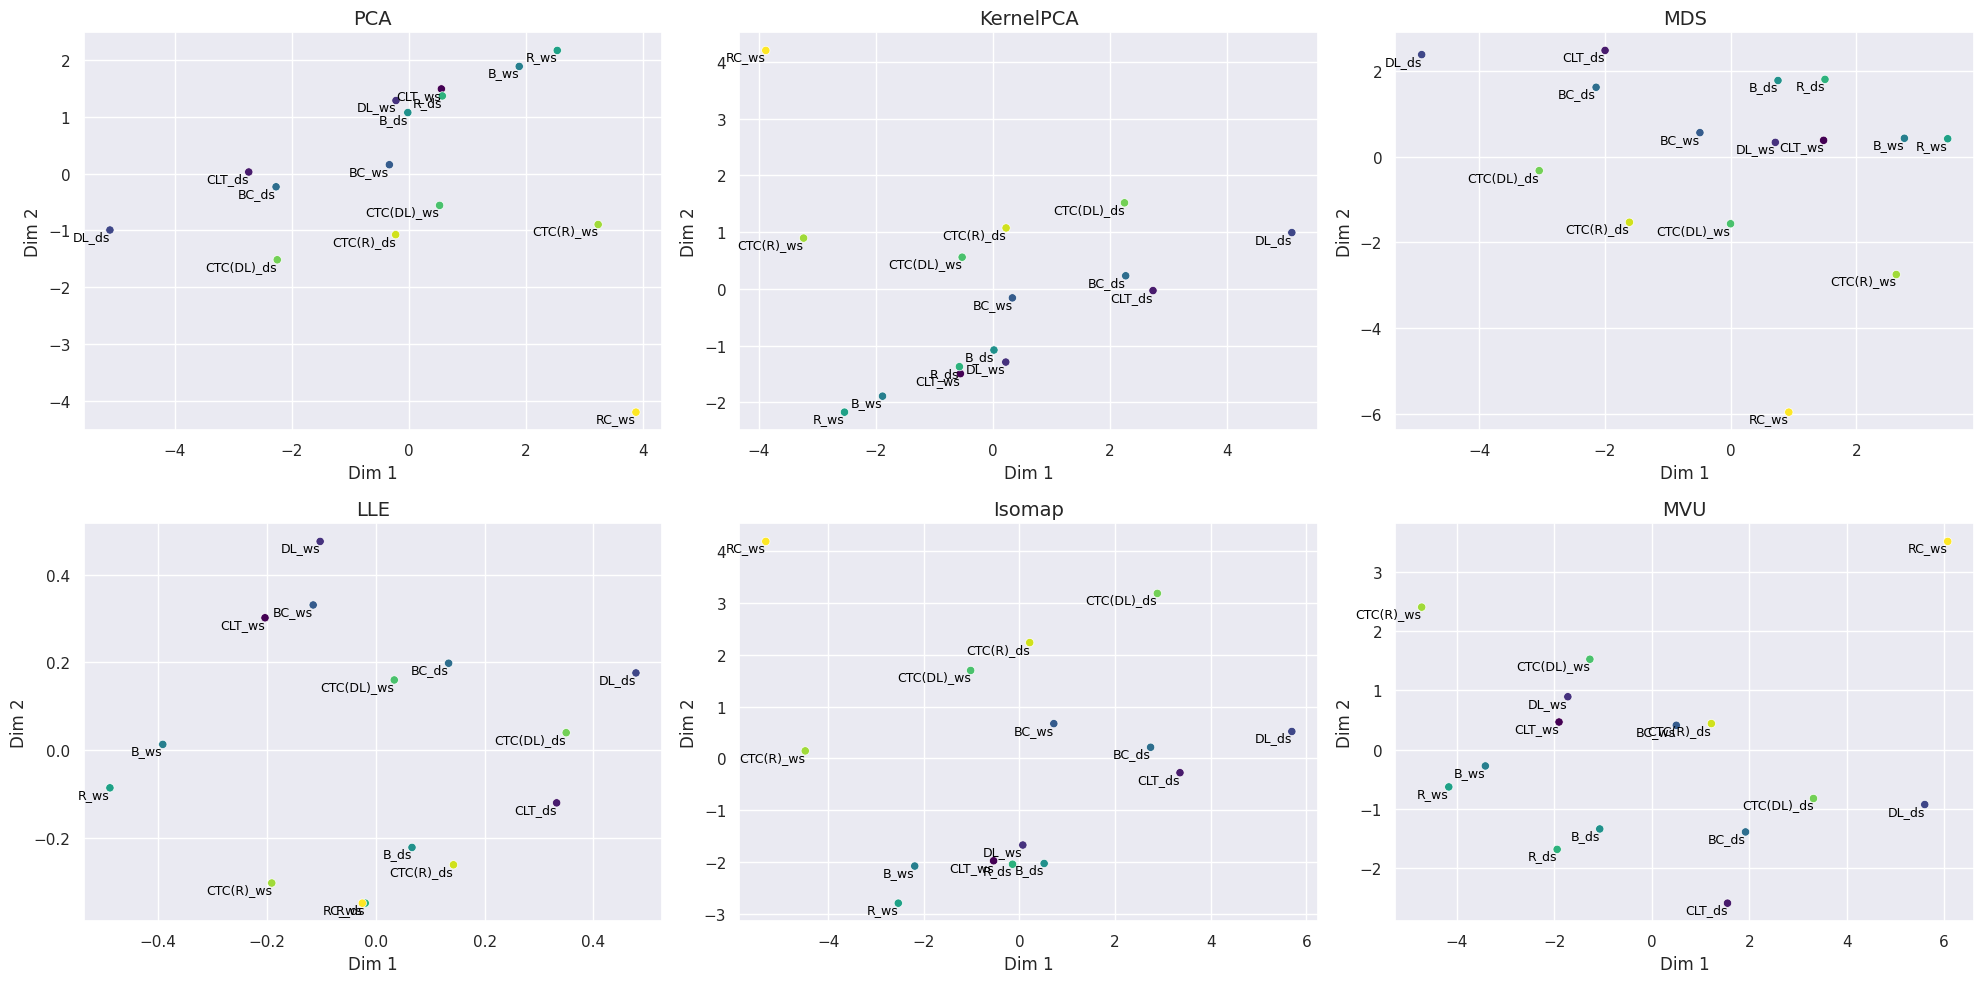

In [9]:
color = np.linspace(0, 1, df.shape[0])
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])

    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    for j in range(df_m.shape[0]):
        axes[i].text(
            df_m.iloc[j, 0],
            df_m.iloc[j, 1],
            str(df_m.index[j]),
            fontsize=9,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
# plt.savefig("data/s-datasets/plots/2d_plane.png")
plt.show()